## Measurement-Induced Phase Transitions in Haar-Random Brickwork Circuits
This notebook uses Quimb to simulate a brickwork circuit of Haar-random unitaries on a 1D chain of qubits. At each layer of the circuit, qubits are projectively measured with some probability $p$. Inverse Participation Ratio (IPR) and Participation Entropy (S) are calculated after each time step as measures of state delocalization and compared for different measurement probabilities.

In [5]:
%config InlineBackend.figure_formats = ['svg']
from quimb.tensor import *
from quimb import *
import numpy as np
import random
import quimb as qu
import quimb.tensor as qtn
import matplotlib.pyplot as plt

#### Choose parameters
Note that n_runs and L scale poorly.

In [6]:
L = 6               # number of qubits
D = 20               # number of layers
n_runs = 100         # number of independent circuit realizations to average over
p_values = [0, .1, 1]  # measurement probability per qubit per layer, will compare all probs in list
colors = ['tab:purple', 'tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:red'] # make sure you have at least enough colors for each probability
rng = np.random.default_rng(None) # random float in [0, 1), replace None with seed (1234) for reproducability

#### Function definitions

For a normalized state vector, we calculate the IPR as follows:
$$
|\psi\rangle = \sum_i c_i |i\rangle, \qquad \mathrm{IPR} = \sum_i |c_i|^4
$$

The participation entropy is defined as:
$$
S_\alpha = \frac{1}{1 - \alpha} \log \left( \sum_i |c_i|^{2\alpha} \right),
$$
where $\alpha$ is the Rényi index and $\alpha = 2$ corresponds to the IPR. This gives $S_2 = -\log(\mathrm{IPR})$.

In [7]:
def random_2q_unitary():
    # generate random 2-qubit unitary
    return qu.rand_uni(4)
def ipr(state):
    # calculate IPR, takes statevector
    state = state / np.linalg.norm(state)
    return np.sum(np.abs(state) ** 4)
def pentropy(ipr):
    # calculate participation entropy from IPR
    return -np.log(ipr)

In [8]:
# define Z-basis projectors to use in measurements
P0 = np.array([[1, 0],[0, 0]], dtype=complex)
P1 = np.array([[0, 0],[0, 1]], dtype=complex)

def z_measure(circ, L, p, rng, round_int):
    # Measure each qubit in Z-basis with prob p using marginals, then collapse with projectors.
    outcomes = [None] * L #initalize list of measurement outcomes
    for j in range(L):
        # for each qubit, continue without measuring if random number [0,1] >= p, measure if < p
        if rng.random() >= p:
            continue

        # unnormalized weights, sum equals current ||psi||^2
        pm = np.asarray(circ.compute_marginal(
                        (j,), 
                        simplify_equalize_norms=False,  # <- avoid 1/0 in Quimb's equalizer
                        simplify_atol=0.0),  
                        dtype=float)
        totalprob = pm.sum()  # current ||psi||^2
        if totalprob <= 0:
            continue
        pm /= totalprob  # normalize to use as Born probabilities

        m = 0 if rng.random() < pm[0] else 1
        outcomes[j] = m
        # DEBUGGING
        # print(f"r:{round_int}, qubit:{j}, pm:{pm}, total prob:{totalprob}, norm:{circ.psi.norm()}")  # debugging
        # print(pm.sum())
        # scale by 1/sqrt(raw outcome weight) so new state has norm ~ 1
        raw_outcome_weight = max(totalprob * (pm[0] if m == 0 else pm[1]), np.finfo(float).tiny)
        scale = 1.0 / np.sqrt(raw_outcome_weight)
        proj = (P0 if m == 0 else P1) * scale

        circ.apply_gate(
            proj,
            j,
            gate_round=round_int,
            tags=("MEAS", f"MEAS_round{round_int}", f"MEAS_q{j}")
        )

    # normalize again to be safe at end (should already be ~1)
    try:
        circ.psi.normalize_()
    except AttributeError:
        nrm = float(abs(circ.psi.norm()))
        if nrm > 0:
            circ.psi.multiply_(1.0 / nrm)

    return outcomes

In [9]:
# projectors (as you have)
P0 = np.array([[1, 0], [0, 0]], dtype=complex)
P1 = np.array([[0, 0], [0, 1]], dtype=complex)

def z_measure_subset(circ, qs_all, pM, round_int, eps=1e-15):
    """
    Decide which qubits to measure with probability pM, then:
      1) compute ONE joint marginal over those qubits
      2) sample ONE bitstring (robust to underflow)
      3) apply per-qubit projectors (commute), equalize once
    Returns: dict {q: 0/1} for the qubits actually measured this layer.
    """
    print("measuring")
    # 1) choose qubits to measure this layer
    qs = [q for q in qs_all if np.random.random() < pM]
    if not qs:
        return {}

    k = len(qs)

    # 2) joint marginal over the chosen subset, shape (2,)*k
    probs = np.asarray(
        circ.compute_marginal(
            tuple(qs),
            simplify_equalize_norms=True,   # keep contraction stable
            simplify_atol=1e-12,
        ),
        dtype=float,
    )

    # 3) robust normalize or fall back
    probs = np.clip(probs, 0.0, None)
    total = float(probs.sum())

    outcomes = {}

    if not np.isfinite(total) or total < eps:
        # Essentially already collapsed; pick argmax per-site from single-qubit marginals.
        # For each axis i, sum over all OTHER axes => vector of length 2
        for i, q in enumerate(qs):
            # sum over all axes except i
            axes_to_sum = tuple(ax for ax in range(k) if ax != i)
            marg_i = probs if k == 1 else probs.sum(axis=axes_to_sum)
            # marg_i now has shape (2,); choose heavier component
            m = 0 if marg_i[0] >= marg_i[1] else 1
            outcomes[q] = int(m)
    else:
        # Proper normalized sampling over the full bitstring
        flat = probs.ravel() / total
        # Guard against rare all-zero after clipping
        if flat.sum() <= 0.0:
            # fallback: per-site argmax as above
            for i, q in enumerate(qs):
                axes_to_sum = tuple(ax for ax in range(k) if ax != i)
                marg_i = probs if k == 1 else probs.sum(axis=axes_to_sum)
                m = 0 if marg_i[0] >= marg_i[1] else 1
                outcomes[q] = int(m)
        else:
            cdf = np.cumsum(flat)
            r = np.random.random()
            idx = int(np.searchsorted(cdf, r, side="right"))
            bits = np.unravel_index(idx, probs.shape)  # tuple of 0/1, length k
            outcomes = {q: int(b) for q, b in zip(qs, bits)}

    # 4) collapse: apply projectors (commuting), then equalize once
    for q in qs:
        proj = up() if outcomes[q] == 0 else down()
        circ.apply_gate(
            proj, q,
            gate_round=round_int,
            unitary=False,  # small speed win for nonunitary ops
            tags=("MEAS", f"MEAS_round{round_int}", f"MEAS_q{q}")
        )

    # keep TN scales tame (cheap)
    circ.psi.equalize_norms_()

    return outcomes



#### Main call and plots

In [10]:
iprs_avg_dict = {} # to store averaged IPRs for each prob since they get overwritten in loop
entropies_avg_dict = {} # "" for entropies
circuits = {} # save circuits to draw

for p, color in zip(p_values, colors): # loop over measurement probs
    iprs_avg = np.zeros(D + 1) # initialize IPRs for 0th + D layers
    entropies_avg = np.zeros(D + 1)
    print('prob:', p)
    print('run:')
    for run in range(n_runs): # loop over n runs
        print(run) # I use this as a progress bar
        circ = qtn.Circuit(N=L) #initialize circuit of length L at start of each run, default all in 0
        iprs = [] # to store ipr at each layer
        entropies = [] # to store each participation entropy
        psi0 = circ.psi.to_dense() # initial state; circ is circuit, psi is tensor network state, to_dense gives single statevector (note this is expensive)
        ipr0 = ipr(psi0) # should be 1
        iprs.append(ipr0)
        entropies.append(pentropy(ipr0)) 

        for r in range(D): # for each layer in depth
            if r % 2 == 0: 
                # at even layers apply random 2-site unitary
                for i in range(0, L - 1, 2):
                    U = random_2q_unitary()
                    circ.apply_gate(U, i, i + 1, gate_round=r) # pairs (0,1), (2,3), ...
            else:
                for i in range(1, L - 1, 2):
                # at odd layers apply random unitary
                    U = random_2q_unitary()
                    circ.apply_gate(U, i, i + 1, gate_round=r) # pairs (1,2), (3,4), ...

            outcomes = z_measure(circ, L, p, rng, round_int=r) #after each layer, measure with prob p
            #_ = z_measure_subset(circ, qs_all=range(L), pM=p, round_int=r)
            state, outcomes = z_measure_2(circ, r, p, rng)

            psi = circ.psi.to_dense()
            ipr_n=ipr(psi)
            iprs.append(ipr_n) # record IPR after each layer and measurement
            entropies.append(pentropy(ipr_n))

        iprs_avg += np.array(iprs) # summing IPR at each layer for each run
        entropies_avg += np.array(entropies)

    iprs_avg /= n_runs # average the array of IPRs over runs
    iprs_avg_dict[p] = iprs_avg  # store avg IPRs with corresponding probability to plot
    entropies_avg /= n_runs
    entropies_avg_dict[p] = entropies_avg
    circuits[p] = circ

# Plot IPR
plt.figure(figsize=(7, 5))
for p, color in zip(p_values, colors):
    xi = range(1, D + 1)
    yi = iprs_avg_dict[p][1:]  # skip t=0
    plt.plot(xi, yi, marker='o', color=color, label=f"p={p}") # you will get an error here if not enough colors in your list

#plt.yscale('log')
plt.xlabel("Timesteps")
plt.ylabel("Average IPR")
plt.title(f"Average IPR for {L} qubits over {n_runs} runs")
plt.grid(True)
plt.legend(title="Measurement prob.")
plt.show()

# Plot S
plt.figure(figsize=(7, 5))
for p, color in zip(p_values, colors):
    xs = range(1, D + 1)
    ys = entropies_avg_dict[p][1:]  # skip t=0
    plt.plot(xs, ys, marker='o', color=color, label=f"p={p}") # you will get an error here if not enough colors in your list

#plt.yscale('log')
plt.xlabel("Timesteps")
plt.ylabel("Average S")
plt.title(f"Average S for {L} qubits over {n_runs} runs")
plt.grid(True)
plt.legend(title="Measurement prob.")
plt.show()


prob: 0
run:
0


NameError: name 'z_measure_2' is not defined

#### IPR value comparison

"The smallest value of the IPR corresponds to a fully delocalized state, $\psi(x) = 1/\sqrt{N}$ for a system of size $N$, where the IPR yields

$$
\sum_x |\psi(x)|^4 = \frac{N}{(N^{1/2})^4} = \frac{1}{N}.
$$

Values of the IPR close to 1 correspond to localized states (pure states in the analogy), as can be seen with the perfectly localized state $\psi(x) = \delta_{x, x_0}$, where the IPR yields

$$
\sum_x |\psi(x)|^4 = 1.
$$

In one dimension, IPR is directly proportional to the inverse of the localization length, i.e., the size of the region over which a state is localized [(Wikipedia)](https://en.wikipedia.org/wiki/Purity_(quantum_mechanics)#Inverse_Participation_Ratio_(IPR))."

For $L$ number of qubits, we have the following values:

Haar-average IPR ($q=2$):
$$I_2^{\mathrm{Haar}} = \frac{2}{d^L \left(d^L + 1\right)}$$

Max participation Entropy:
$$S_2^{\mathrm{max}} = L \ln 2.$$

Haar-average participation entropy ($q=2$):
$$S_2^{\mathrm{Haar}} = \ln\!\left(d^L + 1\right) - \ln 2$$

[(Source)](http://arxiv.org/abs/2404.10725)

In [ ]:
# print stats for each prob
N = 2 ** L # Hilbert space dimension
haar_avg_ipr = 2 / (N + 1) # Average IPR of a Haar-random state for reference

for p in p_values:
    iprs_avg = iprs_avg_dict[p]
    # start looking for min and avg IPR after 10 layers, picked this arbitrarily based on where plots start leveling out
    min_ipr = np.min(iprs_avg[11:])
    avg_ipr_after_t10 = np.mean(iprs_avg[11:])

    print(f"\nResults for p={p}:")
    print(f"  Minimum IPR (t > 10): {min_ipr:.6g}")
    print(f"  Average IPR (t > 10): {avg_ipr_after_t10:.6g}") # probably need much more depth for this to be useful
    print(f"  Haar average IPR for L={L}: {haar_avg_ipr:.6g}")


Results for p=0:
  Minimum IPR (t > 10): 0.000125567
  Average IPR (t > 10): 0.000135749
  Haar average IPR for L=14: 0.000122063

Results for p=0.1:
  Minimum IPR (t > 10): 0.000653848
  Average IPR (t > 10): 0.00102232
  Haar average IPR for L=14: 0.000122063

Results for p=1:
  Minimum IPR (t > 10): 1
  Average IPR (t > 10): 1
  Haar average IPR for L=14: 0.000122063


#### Tensor network drawings

Circuit for p=0


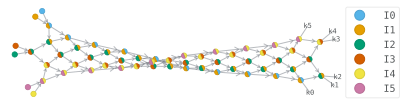

Qubits measured in circuit for p=0


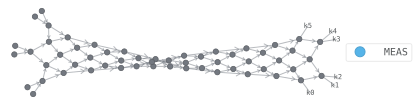

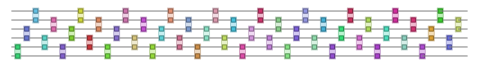

In [ ]:
for p, circ in circuits.items():
    print(f'Circuit for p={p}')
    circ.psi.draw(color=[f'I{i}' for i in range(L)], show_tags=False)
    print(f'Qubits measured in circuit for p={p}')
    circ.psi.draw(color=["MEAS"], show_tags=False)
    circ.draw()

#### 3D Plot of IPR vs. Measurement Probability vs. Time

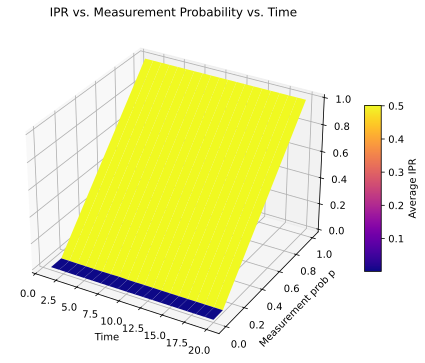

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# convert iprs_avg_dict into arrays for plotting
p_vals = sorted(iprs_avg_dict.keys())
times = np.arange(D + 1)
times = times[1:]  # skip t=0

# Create meshgrid
T, P = np.meshgrid(times, p_vals)

# Z array: each row is iprs for one p (skip first entry)
Z = np.array([iprs_avg_dict[p][1:] for p in p_vals])

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# plot the surface
surf = ax.plot_surface(
    T, P, Z,
    rstride=1, cstride=1,
    cmap='plasma',
    edgecolor='none',
    antialiased=True
)

ax.set_xlabel("Time")
ax.set_ylabel("Measurement prob p")
#ax.set_zlabel("Average IPR")
ax.set_title("IPR vs. Measurement Probability vs. Time")

fig.colorbar(surf, shrink=0.5, aspect=10, label="Average IPR")

plt.show()

In [ ]:
import numpy as np
import quimb as qu

def z_measure_2(circ, layer_idx, pM, rng=None):
    """
    Apply Z-basis measurements to each qubit in a circuit with probability pM.

    Parameters
    ----------
    circ : qtn.Circuit
        The circuit to measure from.
    layer_idx : int
        Tag to add so you know which round/layer the measurement belongs to.
    pM : float
        Probability (0 ≤ pM ≤ 1) of measuring each qubit.
    rng : np.random.Generator, optional
        Random generator for reproducibility.

    Returns
    -------
    state : np.ndarray
        The collapsed statevector after measurement.
    outcomes : dict
        Mapping qubit index → measurement eigenvalue (±1), for qubits measured.
    """
    if rng is None:
        rng = np.random.default_rng()

    L = circ.N
    dense = circ.psi.to_dense()
    outcomes = {}

    for q in range(L):
        if rng.random() < pM:
            Z = qu.pauli('Z')
            A = qu.ikron(Z, [2]*L, q)
            result, dense = qu.measure(dense, A)
            outcomes[q] = result

            # (optional) tag circuit with measurement event
            #circ.add_tag(f"MEAS_q{q}_layer{layer_idx}")

    return dense, outcomes


In [ ]:
def choose_qubits(L, p, rng=np.random.default_rng()):
    return [q for q in range(L) if rng.random() < p]

def sample_qubits(circ, qubits, rng=np.random.default_rng()):
    if not qubits:
        return {}
    # circ.sample yields bitstrings over the chosen qubits
    bitstr = next(circ.sample(C=1, qubits=qubits, simplify_atol=1e-06, simplify_equalize_norms=True, seed=rng.integers(1e9)))
    return {q: int(b) for q, b in zip(qubits, bitstr)}

P0 = np.array([[1, 0], [0, 0]], dtype=complex)
P1 = np.array([[0, 0], [0, 1]], dtype=complex)

circ = qtn.Circuit(N=2)
circ.apply_gate('H', 0)   # make qubit 0 in superposition
r=0
outcomes = z_measure_2(circ, r, pM=0.5)
print("Measured outcomes:", outcomes)
print("Norm after collapse:", circ.psi.norm())

Measured outcomes: (array([[0.70710678+0.j],
       [0.        +0.j],
       [0.70710678+0.j],
       [0.        +0.j]]), {})
Norm after collapse: (0.9999999999999999+0j)
